# Minimal Model

This notebook presents an agent-based model that simulates the propagation of a disease through a network.
It demonstrates how to use the [agentpy](https://agentpy.readthedocs.io) package to create and visualize networks, use the interactive module, and perform different types of sensitivity analysis. 

In [4]:
# Model design
import agentpy as ap
import networkx as nx 
import random 
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns
import IPython

np.random.seed(42)

## About the model

The agents of this model are people, which can be in one of the following three conditions: susceptible to the disease (S), infected (I), or recovered (R). The agents are connected to each other through a small-world network of peers. At every time-step, infected agents can infect their peers or recover from the disease based on random chance.

## Defining the model

We define a new agent type :class:`Person` by creating a subclass of :class:`Agent`.
This agent has two methods: :func:`setup` will be called automatically at the agent's creation,
and :func:`being_sick` will be called by the :func:`Model.step` function.
Three tools are used within this class:

- :attr:`Agent.p` returns the parameters of the model
- :func:`Agent.neighbors` returns a list of the agents' peers in the network
- :func:`random.random` returns a uniform random draw between 0 and 1

wealth by race https://www.federalreserve.gov/econres/notes/feds-notes/disparities-in-wealth-by-race-and-ethnicity-in-the-2019-survey-of-consumer-finances-20200928.html

rank for the US:
https://www.federalreserve.gov/econres/notes/feds-notes/wealth-inequality-and-the-racial-wealth-gap-accessible-20211022.htm#fig3


In [5]:
class Person(ap.Agent):
    
    def setup(self):  
        """ Initialize a new variable at agent creation. """
        # self.condition = 0  # Susceptible = 0, Infected = 1, Recovered = 2
        a = 5 # shape
        rng = np.random.default_rng()
        self.wealth = 1
        self.race = 0
            

        # fraud
        self.fraud = rng.binomial(1,self.p.fraud_rate,1)[0]
        self.fraud_pred = -1
        self.convicted = 0

        
        
    
            
            
    def convict_true(self):
        """ Conviction and Consequences"""
        rng = np.random.default_rng()
        if self.fraud == 1:
            if rng.binomial(1,self.p.conviction_rate) == 1:
                # pay fine, get on record, 
                self.wealth = self.wealth - (0.01)#(self.wealth*0.05)])
                self.convicted =+ 1
                self.fraud = rng.binomial(1,self.p.fraud_rate,1)[0]

        else:
            self.fraud = rng.binomial(1,self.p.fraud_rate,1)[0]
            


        
            


Next, we define our model :class:`VirusModel` by creating a subclass of :class:`Model`.
The four methods of this class will be called automatically at different steps of the simulation,
as described in :ref:`overview_simulation`.

In [6]:
class VirusModel_mvp(ap.Model):
    
    def setup(self): #before
        """ Initialize the agents and network of the model. """

#         # Create agents and network
        self.agents = ap.AgentList(self, self.p.agents, Person)
    

    def step(self): # during each step
        """ Define the models' events per simulation step. """
#         self.agents.fraud_algo()
#         self.agents.appeal()
        self.agents.convict_true()
#         self.agents.wealth_grow()
        



    def update(self):  # after each step
        """ Record variables after setup and each step. """
        self.agents.record('wealth')
        self.agents.record('fraud_pred')
        self.agents.record('fraud')
        self.agents.record('race')
        
        
    
    def end(self):     
        """ Record evaluation measures at the end of the simulation. """

        
        # general wealth 
        wealth = sum((self.agents).wealth) / len((self.agents))
        
        self.report('wealth_total', sum((self.agents).wealth) )
        self.report('wealth', wealth)
#         self.report('fraud_rate', self.p.fraud_rate)
            
            
        

In [7]:
parameters = {

    'my_parameter':42,
    'agents': 100, #ap.IntRange(50, 150),
    'steps':100,
    'fraud_rate': ap.Range(0.,1),
#     'wealth_start': ap.Range(0.5,1), #ap.Range(-0.2, 0.2), # >0 more wealth higher appeal chance
    'conviction_rate': 1, #ap.Range(0,1), # ap.Range(0,1),
} 

sample = ap.Sample(
    parameters, 
    n=128, 
    method='saltelli', 
    calc_second_order=False
)


exp = ap.Experiment(VirusModel_mvp, sample, iterations=2, record = True)
results = exp.run()

Scheduled runs: 768
Completed: 768, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:02:23.413503


The measures in our :class:DataDict now hold one row for each simulation run.

We can use standard functions of the pandas library like :func:pandas.DataFrame.hist to look at summary statistics.
Sensitivity analysis

We can also display sensitivities by plotting average evaluation measures over our parameter variations.

In [8]:
# make the plot mathematically
x_coords = np.arange(0,1, 0.01)

math_calc = pd.DataFrame(
    {'x_coords': x_coords,
     'y_coords': [1 - x*0.01*100 for x in x_coords]
    })


fraud_rate


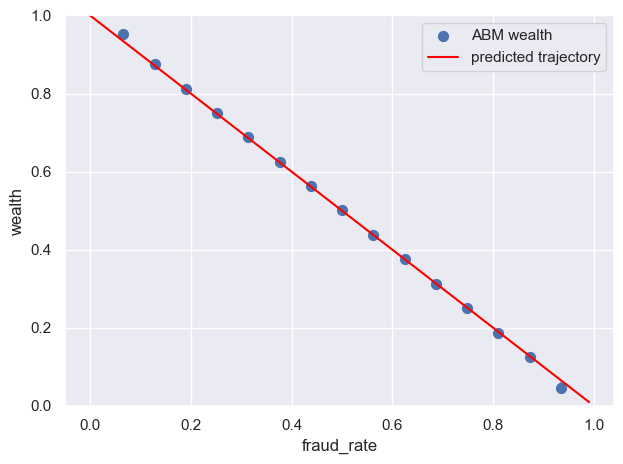

In [9]:
def plot_sensitivity(results):
    """ Show average simulation results for different parameter values. """
    
    sns.set()
#     fig, axs = plt.subplots(2, 2, figsize=(8, 8))
#     axs = [i for j in axs for i in j] # Flatten list
    
    fig, ax = plt.subplots()
    
    data = results.arrange_reporters().astype('float')[["sample_id", "iteration", 'wealth', "fraud_rate"]]
    params = results.parameters.sample.keys() 

    for x in (params):
        for y in ['wealth']:
            print(x)
            sns.regplot(x=x, y=y, data=data, ci=99, 
                        x_bins=15, fit_reg=False, label= "ABM wealth")  
        ax.set_ylim(0,1)
        ax.set_ylabel('wealth')
        ax.legend()
        
    sns.lineplot(data = math_calc,y ='y_coords', x = 'x_coords', color = 'red', label = 'predicted trajectory')
        
    plt.tight_layout()

plot_sensitivity(results)

## Running a simulation

To run our model, we define a dictionary with our parameters. 
We then create a new instance of our model, passing the parameters as an argument, 
and use the method :func:`Model.run` to perform the simulation and return it's output. 

Completed: 50 steps
Run time: 0:00:00.995864
Simulation finished


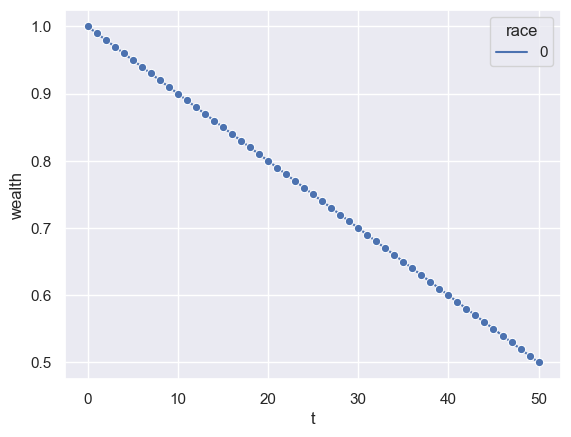

In [11]:
parameters = {
    'my_parameter':42,
    'agents':1000,
    'steps':50,
    'fraud_rate':1, 
    'wealth_appeal_corr': 0, # >0 more wealth higher appeal chance
    'acc': 0.8, # accuracy of fraud prdediction
    'conviction_rate': 1,
    'appeal_wealth': 0.2 # minimal wealth needed for appeal (could also become a param for distr. eventually)
    #'wealth_impact'
    
}

model = VirusModel_mvp(parameters)
results = model.run() 

df = results['variables']['Person']
fig, ax = plt.subplots()

sns.lineplot(ax = ax,
             data = df,
             x = df.index.get_level_values('t'),
             y = df['wealth'].astype(float),
             hue = df['race'],
             marker = 'o')

plt.show()

Completed: 50 steps
Run time: 0:00:01.075596
Simulation finished


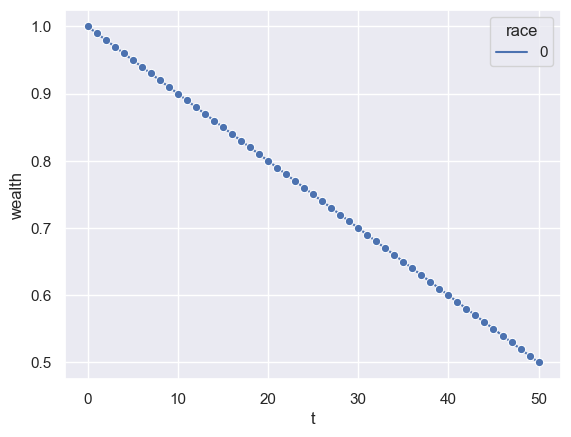

In [12]:
model = VirusModel_mvp(parameters)
results_mvp = model.run() 

df = results['variables']['Person']
fig, ax = plt.subplots()

sns.lineplot(ax = ax,
             data = df,
             x = df.index.get_level_values('t'),
             y = df['wealth'].astype(float),
             hue = df['race'],
             marker = 'o')

plt.show()

## Analyzing results

The simulation returns a :class:`DataDict` of recorded data with dataframes:

In [13]:
r =results['variables']['Person']
rmvp = results_mvp['variables']['Person']
x = r.index.get_level_values('t')
y = r['wealth'].astype(float)
hue = r['race']
xmvp = rmvp.index.get_level_values('t')
ymvp = rmvp['wealth'].astype(float)
huemvp = rmvp['race']

In [24]:
dy = ymvp - y


In [20]:
rw_mvp = rmvp[['wealth','race']]
rw_mvp

wealth  race
obj_id t               
1      0     1.00     0
       1     0.99     0
       2     0.98     0
       3     0.97     0
       4     0.96     0
...           ...   ...
1000   46    0.54     0
       47    0.53     0
       48    0.52     0
       49    0.51     0
       50    0.50     0

[51000 rows x 2 columns]

In [21]:
rw_mvp0 = (rmvp.loc[rmvp['race'] == 0]['wealth']).groupby('t').mean()
rw_mvp1 = (rmvp.loc[rmvp['race'] == 1]['wealth']).groupby('t').mean()

# rw_mvp0-rw_mvp1

In [22]:
r0 = (r.loc[r['race'] == 0]['wealth']).groupby('t').mean()
r1 = (r.loc[r['race'] == 1]['wealth']).groupby('t').mean()

# r0-r1

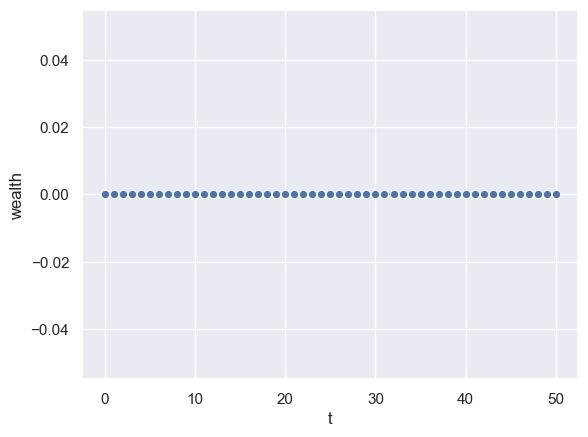

In [25]:
fig, ax = plt.subplots()
df = results['variables']['Person']
sns.lineplot(ax = ax,
             data = df,
             x = r.index.get_level_values('t'),
             y = dy,
#              hue = hue,
             marker = 'o')

plt.show()

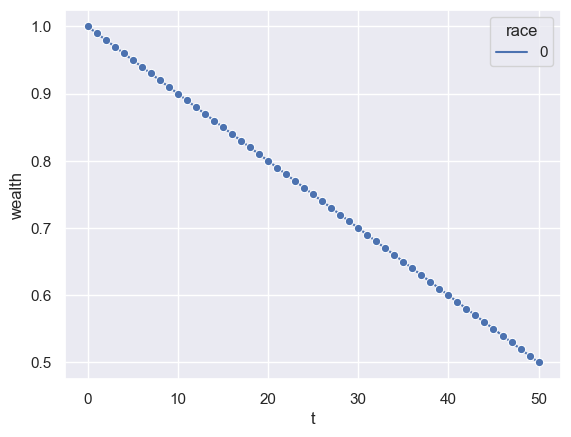

In [26]:
df = results['variables']['Person']
fig, ax = plt.subplots()

sns.lineplot(ax = ax,
             data = df,
             x = df.index.get_level_values('t'),
             y = df['wealth'].astype(float),
             hue = df['race'],
             marker = 'o')

plt.show()

## Multi-run experiment Base Case

To explore the effect of different parameter values, 
we use the classes :class:`Sample`, :class:`Range`, and :class:`IntRange`
to create a sample of different parameter combinations.

What I want is trying a bunch of 

In [19]:
parameters = {
    'my_parameter':42,
    'agents': 100, #ap.IntRange(50, 150),
    'steps':50,
    'fraud_rate': ap.Range(0.,1),
    'wealth_appeal_corr': 0, #ap.Range(-0.2, 0.2), # >0 more wealth higher appeal chance
    'acc': 0.8, #ap.Range(0.5, 0.8), # accuracy of fraud prdediction
    'conviction_rate': 1, # ap.Range(0,1),
    'appeal_wealth': 0.2 # minimal wealth needed for appeal (could also become a param for distr. eventually)
    #'wealth_impact'
} 

sample = ap.Sample(
    parameters, 
    n=128, 
    method='saltelli', 
    calc_second_order=False
)

We then create an :class:`Experiment` that takes a model and sample as input.
:func:`Experiment.run` runs our model repeatedly over the whole sample 
with ten random iterations per parameter combination.

In [20]:
exp = ap.Experiment(VirusModel_mvp, sample, iterations=5, record = True)
results = exp.run()

Scheduled runs: 1920
Completed: 1920, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:02:12.361805


Optionally, we can save and load our results as follows:

In [21]:
results.save()

Data saved to ap_output/VirusModel_mvp_5


In [145]:
results = ap.DataDict.load('VirusModel_mvp')

Loading from directory ap_output/VirusModel_mvp_5/
Loading parameters_sample.csv - Successful
Loading parameters_constants.json - Successful
Loading reporters.csv - Successful
Loading info.json - Successful
Loading variables_Person.csv - Successful
Loading parameters_log.json - Successful


In [148]:
# results['reporters']

The measures in our :class:`DataDict` now hold one row for each simulation run.

We can use standard functions of the pandas library like 
:func:`pandas.DataFrame.hist` to look at summary statistics.

## Sensitivity analysis

We can also display sensitivities by plotting 
average evaluation measures over our parameter variations. 

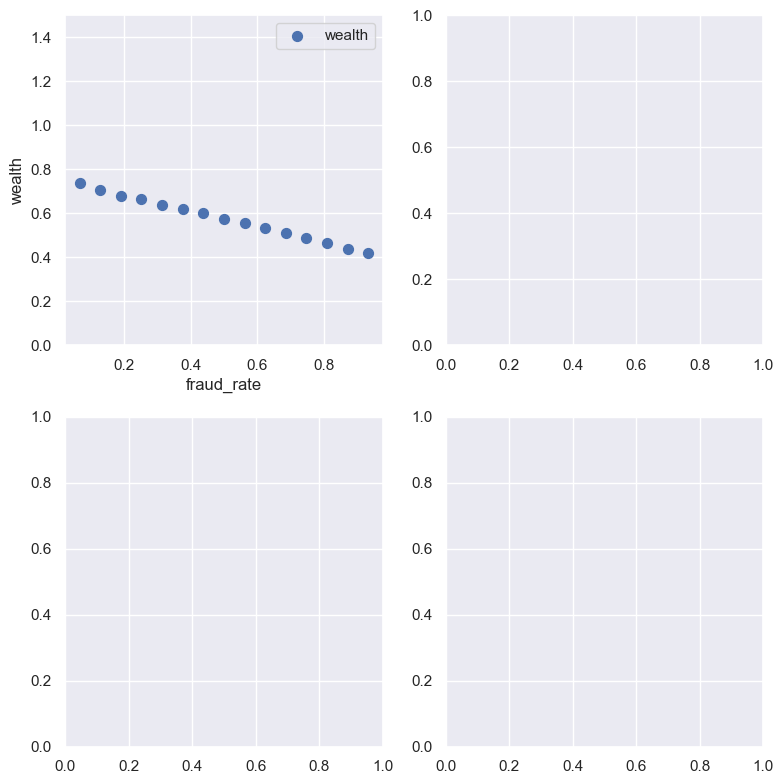

In [156]:
def plot_sensitivity(results):
    """ Show average simulation results for different parameter values. """
    
    sns.set()
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    axs = [i for j in axs for i in j] # Flatten list
    
    data = results.arrange_reporters().astype('float')[["sample_id", "iteration", 'wealth', "fraud_rate"]]
    params = results.parameters.sample.keys() 
    
    for x, ax in zip(params, axs):
        for y in ['wealth']:
            sns.regplot(x=x, y=y, data=data, ax=ax, ci=99, 
                        x_bins=15, fit_reg=False, label=y)  
        ax.set_ylim(0,1.5)
        ax.set_ylabel('wealth')
#         ax.set_xlabel('wealth')
        ax.legend()
        
    plt.tight_layout()

plot_sensitivity(results)